In [ ]:
 from google.colab import drive
import cv2
drive.mount('/content/gdrive')
import numpy as np
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
# 각 단계는 유기적인 관계가 있어 파악하기 쉽도록 순서를 부여하였음 (가,나,다 ...)


Mounted at /content/gdrive


In [ ]:
# 코드 가독성 향상 및 여러 이미지 사용
# image_path = '/content/gdrive/My Drive/ColabIP/Images/london_underground.jpg' # 최초의 지하철

image_path = '/content/gdrive/My Drive/ColabIP/Images/baekdu.jpeg'

목적 : 화질 개선 및 지질에 대한 정보를 평균적으로 상세화

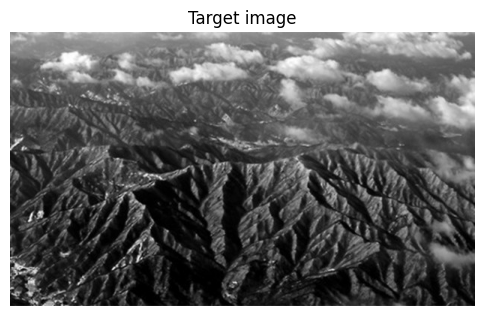

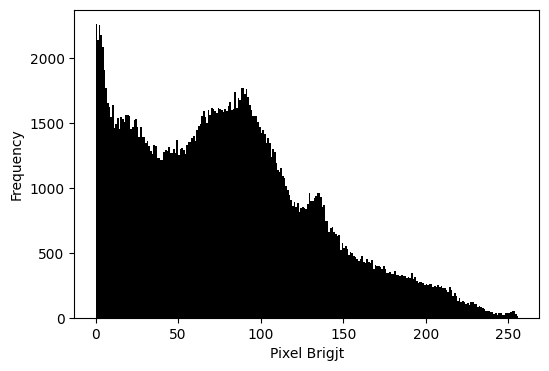

In [ ]:
# 영상 읽기
# greyscale( 색상 정보 없이 밝기 차이로만 영상을 구성, 각 픽셀은 0{완전한 검은색} ~ 255{순백색}의 값을 가짐 )

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) #사진을 그레이스케일로 변환


plt.figure(figsize=(6, 6))
plt.title("Target image")
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(img.ravel(), bins=256, range=(0, 256), color="black")
plt.xlabel("Pixel Brigjt")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# 가우시안 블러(가)
# 목적: 원본 영상을의 노이즈를 제거하여 잡음에 민감한 라플라시안 필터가 더욱 효과적이도록 전처리하기 위함.


# 노이즈나 불필요한 고주파 성분을 제거
# 즉, 후술할 라플라시안 필터가 노이즈가 아닌 실제 경계와 엣지에 집중하도록 전처리

# ksize (n , n) 커널은 홀수개
# n by n 커널을 만듬
# 커널의 크기가 클수록 블러링이 강해져 많은 세부 정보가 제거됨.


# sigmaX=0
# 가우시안 분포의 표준편차를 X축 방향으로 설정함
# 값 대신 0을 입력하면 sigma=X와 같은 효과를 발생
# sigmaX 높아지면 블러링 강화, 디테일이 부드러워짐(뭉개짐) / 낮을수록 블러링 약화 선명해짐

# summary : 노이즈가 많으면 강하게 걸어 ksize를 5 by 5 , sigmaX를 1~2로 설정 / 디테일을 살리고 싶으면 약하게 걸어 ksize를 3 by 3 sigmaX=0

blur = cv2.GaussianBlur(img, ksize=(3,3), sigmaX=0)
#blur = cv2.GaussianBlur(img, ksize=(7,7), sigmaX=2)

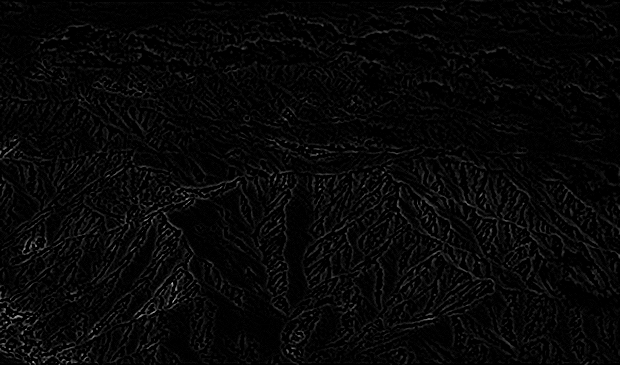

In [ ]:
# 가우시안 블러 적용한 영상에 라플라시안 필터(나) 적용
# 목적 : 라플라시안의 특성을 이용해 극점의 고주파 성분을 강조하여 엣지가 강조된 영상을 만들기 위함.
# 즉, 라플라시안 필터는 변화가 급격해지는 경계의 고주파 성분을 강조함




laplacian_kernal = np.array([ # 커널 영역의 가중치 합산이 0이 되어야함
    [0,2,0],
    [2,-8,2],
    [0,2,0]
]) # 위 커널은 중심 픽셀에 -4를 곱하고 상하좌우 인접 픽셀에 +1을 곱하여서 모두 합산( 중심 계수가 커지면 경계가 강조되고 과도하면 결과가 왜곡됨.)

laplacian = cv2.filter2D(blur, -1, laplacian_kernal) # -1을 입력하면 출력 영상의 데이터 타입이 입력 영상과 동일하게 처리

cv2_imshow(laplacian) # 커널의 가중치 곱연산에 의해 경계가 아닌 곳의 값은 작아져 경계만 강조되게 됨.


# 가우시안 블러(가) 에 의한 영향 분석
# 가우시안 블러를 강하게 건 경우 : 잡음이 거의 사라지고 라플라시안의 엣지 검출이 더 정확해지나 미세한 정보가 사라짐
# 가우시안 블러를 약하게 건 경우 : 노이즈에 의해 불필요한 경계가 검출될 가능성 존재

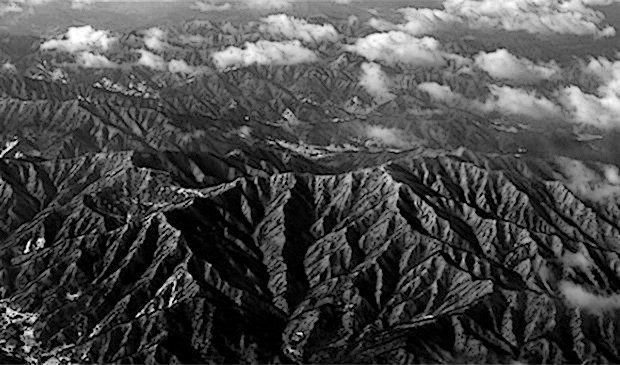

In [ ]:
# 원본(img) 에 라플라시안 필터 결과 성분을 빼는 연산 수행(img - laplacian) (다)
# 목적 : 원본 이미지에서 강하게 검출된 경계를 스무딩하거나 제거하기 위함임.
# 밝은 영역은 경계가 제거된 부분, 어두운 영역은 라플라시안 필터에 의해 감지된 경계 부분

mask_lapl = cv2.subtract(img, laplacian) # substract: 픽셀 단위로 빼기 연산 수행
cv2_imshow(mask_lapl)

# 라플라시안 필터(나)의 영향
# 라플라시안 커널의 중심값 높음 = 강한 경계 필터링 => 경계 부분이 더욱 약화
# 라플라시안 커널의 중심값 낮음 = 약한 경계 필터링 => 경계 부분이 남음

# 가우시안 블러(가)의 영향
# 가우시안 블러가 강한 경우 라플라시안 필터 결과가 더 부드러워져 빼기 연산 후 디테일이 남음
# 가우시안 블러가 약한 경우 잔상 발생

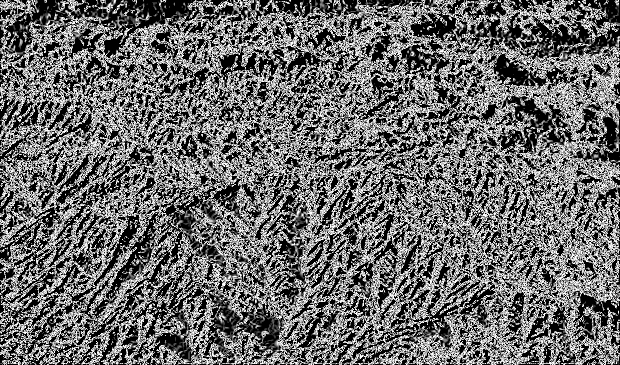

In [ ]:
# 원본에 쇼벨 필터(라) 적용
# 목적 : 쇼벨 필터를 통해 엣지를 검출하여 후술할 평균 필터를 위한 전처리 역할을 수행


sobel_x_kernal = np.array([ # X축 방향(수평 경계) 감지 => 중심 픽셀의 좌우 픽셀간 밝기 차이를 계산해서 수평상 경계 검출
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
])
sobel_y_kernal = np.array([ # Y축 방향(수직 경계) 감지 => 중심 픽셀의 상하 픽셀 간 밝기 차이를 계산하여 수직상 경계 검출
    [-1,-2,-1],
    [0,0,0],
    [1,2,1]
])
sobel_x_value = cv2.filter2D(img, -1, sobel_x_kernal) # 각 축의 경계 정보 필터링
sobel_y_value = cv2.filter2D(img, -1, sobel_y_kernal)

# 2D 행렬 크기 계산
size_value = np.sqrt(np.square(sobel_x_value) + np.square(sobel_y_value)) # 각 방향의 경계값을 기반으로 2차원 경계 강도 계산

# NORM_MINMAX 사용을 위해선 uint8 로 디코딩 필요
size_value = size_value.astype(np.uint8)

sobel = cv2.normalize(size_value, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U) # NORM_MINMAX => 값을 0 ~ 255로 졍규화
cv2_imshow(sobel) # 밝은 부분은 경계가 강한 곳, 어두운 부분은 경계가 약하거나 없는 곳

#cv2_imshow(sobel_x_value) # 수평 경계 확인용
#cv2_imshow(sobel_y_value) # 수직 경계 확인용

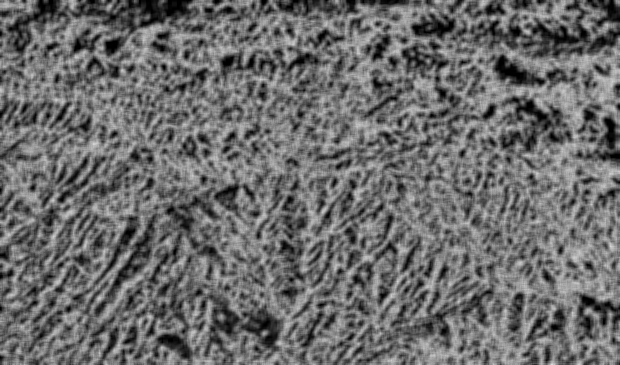

In [ ]:
# 쇼벨 필터 적용한 영상을 5 by 5 커널로 평균 블러(마)
# 목적 : 엣지가 강조된 쇼벨 필터 결과를 스무딩해 튀는 부분을 부드럽게 완화시키고자함


avg_kernal = np.ones((5,5), np.float32) / 25 # 5 by 5 커널 생성하여 25로 나눠 모든 요소가 1을 가지도록 함
avg_blur = cv2.filter2D(sobel, -1, avg_kernal) # -1 은 입력 영상과 동일한 타입으로 출력하기 위함
cv2_imshow(avg_blur)

# 위의 커널의 크기는 클수록 부드러워짐

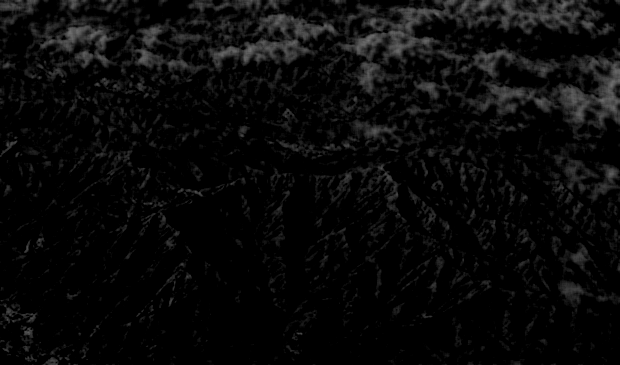

In [ ]:
# 라플라시안, 평균 필터링을 거친 쇼벨 결과를 합한 영상 (바)
# 목적: 가우시안& 라플라시안 / 쇼벨& 평균 필터링의 장점을 합쳐 특징을 유지하고 성분을 평균화한 영상 성분을 만들기 위함.

# cv2.addWeighted(input1, input1의 비율, input2, input2의 비율 , 명암 조절 값)
# 명암 조절값은 픽셀 값에 그대로 더하는 것이므로 음수이면 0으로 향해 전체적으로 어두워지고 양수이면 255로 향해 전체적으로 밝아짐

mask = cv2.addWeighted(mask_lapl, 0.5, avg_blur, 0.5, -100)  # 같은 비율로 합산하겠다
cv2_imshow(mask)
# 위와 같은 경우 mask_lapl이 강해지면 경계를 강조하고 sobel을 강조하면 경계가 스무딩됨

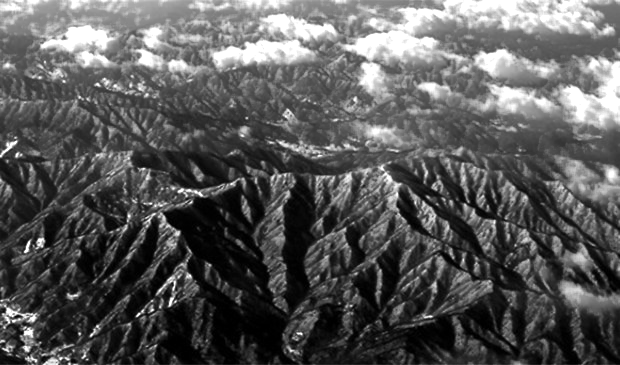

In [ ]:
# 원본영상과 필터 영상을 합함 (사)
# 목적 : 원본 영상과 처리한 영상 성분을 합치긱 위함
# cv2.add => 더하기 연산
final = cv2.add(img, mask)
cv2_imshow(final)

# 파라미터의 영향
# mask(바)가 라플라시안을 강하게 건 경우 경계가 강해짐 / 평균, 쇼벨을 강하게 건 경우 경계가 스무딩

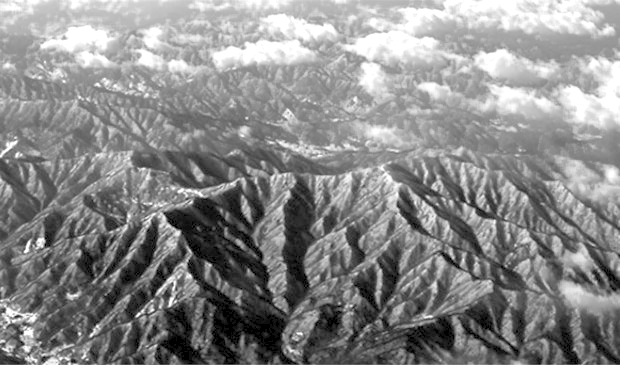

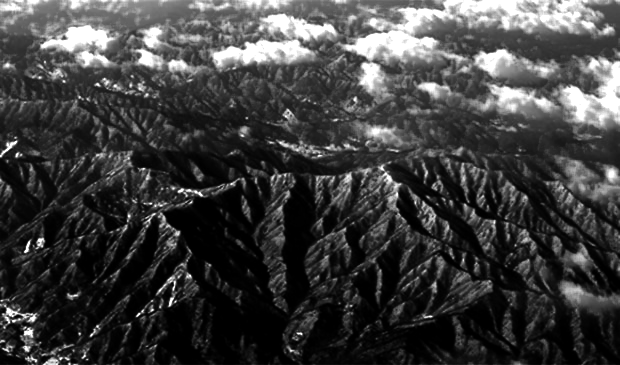

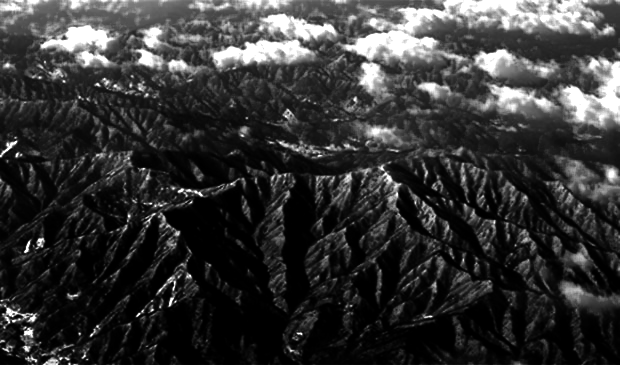

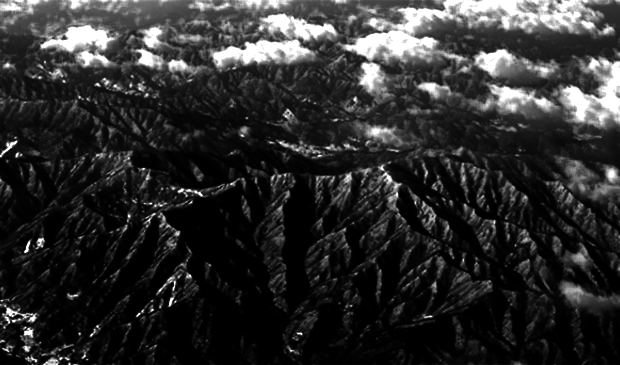

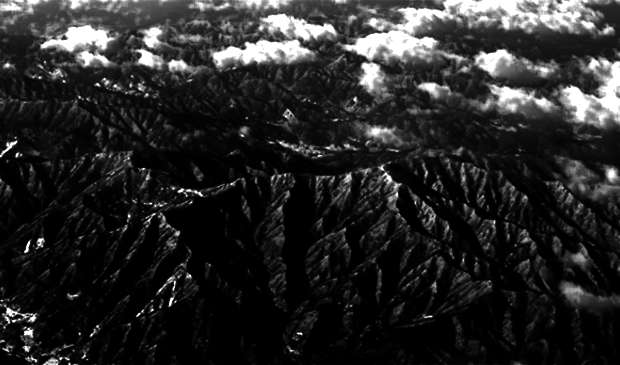

In [ ]:
# 여러 밝기 가중치를 final에 적용해보고 최종 적합한 영상의 가중치 조정 (아)
# 목적 : 여러 밝기 값을 비교해보고 적절한 사진을 택하기 위함

gamma = [0.5,1.5,1.8,2.1,2.4] # gamma 클수록 어두움, 작을수록 밝음
for i in range(len(gamma)):
  result = np.array(255*(final/255)**gamma[i], dtype='uint8') # final/255 => 픽셀값을 0 혹은 1로 만듬
                                                              # 영상간 밝기 대비의 극적인 차이를 위해 감마를 거듭제곱 하여 명암비를 비선형적으로 만듦
  cv2_imshow(result)
  # 내리면서 각 감마값 비교

In [ ]:
# 영상을 담은 리스트 생성
images = [img, result] # 0: 원본 영상 1: 감마 보정 결과 영상

# 결과 사진 처리
result = np.array(255*(final/255)**gamma[1], dtype='uint8') # gamma[1] 리스트의 2번째 값인 1.5 를 사용하겠다.
#  원본 영상 접근
img_cal = cv2.calcHist(images[0], channels=[0], mask=None, histSize=[64], ranges=[0,256]) # images[0] : 원본
# 결과 영상 접근
result_cal = cv2.calcHist(images[1], channels=[0], mask=None, histSize=[64], ranges=[0,256]) # image[1] : 감마 보정 결과


# cv2.calcHist(원본 영상, 영상의 채널, 전체 이미지 사용 여부 , 히스토그램 값 구간 개수, 픽셀 값 범위 )
# 영상의 채널은 흑백이면 0
# 전체 이미지 사용 하려면 mask=None

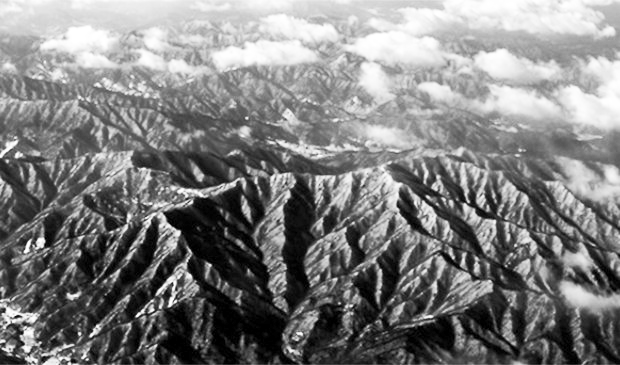

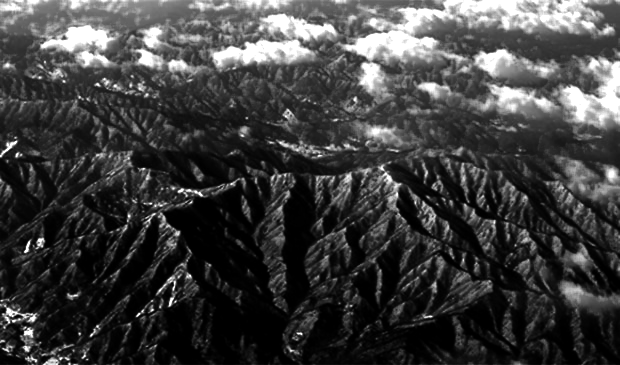

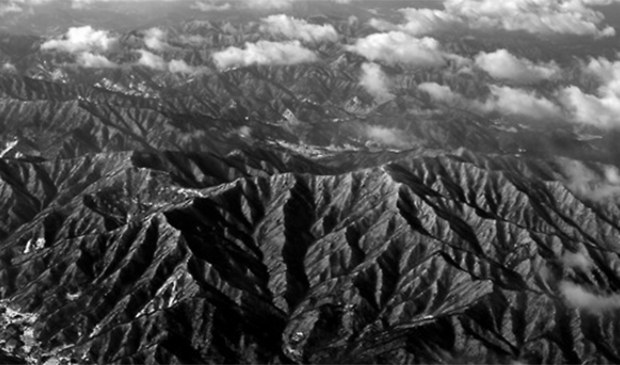

In [ ]:
# 히스토그램 평활화
# 픽셀의 분포를 균등하게 만들어 대비를 높이고 세부사항이 강조됨
hist = cv2.equalizeHist(img)
hist_cal = cv2.calcHist(images=[hist], channels=[0], mask=None, histSize=[64], ranges=[0,256])

cv2_imshow(hist) # 대비가 강화된 영상
cv2_imshow(result) # 밝기 값까지 선택한 최종 특징 개선 영상
cv2_imshow(img) # 원본 영상